## Курсовая работа по курсу "Рекомендательные системы"

 **ОГЛАВЛЕНИЕ**
* Разделы:
    * [0. Постановка задачи.](#task)
    * [1. Загрузка и просмотр данных.](#load)
    * [3. Первый уровень. Поиск лучшего метода.](#first_level) 
    * [4. Второй уровень. Улучшение базовой модели 1-го уровня.](#second_level)
    * [5. Вывод.](#end)

**Задача курсовой:** 

0) Закрепить навыки, полученные на курсе рекомендательные системы;

1) Выявить закономерности(паттерны) поведения(покупок) покупателя на предложенных данных,
    сформировать рекомендации на их основании и предложить товары для некторого интервала 
            времени покупок покупателя(проверка на retail_test1 -> 3 недели с 96-й по 98-ю включительно).
                Применяется только "тёплый старт  (когда есть итория покупок покупателя).  
        

2) Преодолеть порог метрики precision@5 = 0.22 на retail_test1 
    без дробления retail_test1 на части(по неделям, дням, корзинам и т.д).


Пояснения:
* Данная курсовая работа построена на базе домашних заданий, которые были выполнены в рамках данного курса. 
* В данной рабочей тетрадке не отражены экперименты, проведенные в рамках выполнения курсовой работы. 

# Загрузка и подготовка данных <a class='anchor' id='load'>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from metrics import precision_at_k, recall_at_k
from utils import prefilter_items
from recommenders import MainRecommender

import warnings
warnings.filterwarnings('ignore')

In [2]:
# В дальнейшем можно перенести функции в загружаемые модули. Здесь размещено для простоты поиска.

#metrics
def calc_precision(df_data, top_k):
    """ Расчет точности на предоставленных данных.
    df_data - данные, где должны быть столбцы с user_id, actual_col(реальные покупки покупателя): list, recommendation: list;
    top_k - значение для расчета точности actual_col, recommendation.
    """
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

#recommenders    
def global_popularity_rec(data, n=5):
    """Топ-n популярных товаров среди всех покупателей.
    data - данные для выявления популярных товаров;
    n - выбор Топ-n товаров.
    """
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    recs = popular.head(n).item_id
    
    return recs.tolist()


def self_popularity_rec(user, data, n=5):
    """Топ-n популярных товаров одного пользователя.
    user - пользователь: int;
    data - данные с покупками пользователя за выбранный период;
    n - выбор Топ-n товаров.
    """
    recs_for_user = data[data['user_id'] == user]['item_id'].value_counts().index[:n].tolist()
    
    # Если не хватает товаров у пользователя, то добавить товары из глобального топа товаров 
    if len(recs_for_user) < n:
        recs_for_user += data['item_id'].value_counts().index[:5].tolist()[:(n - len(recs_for_user))]
        
    return recs_for_user

In [3]:
# Второй уровень для self_popular_rec

#utils
def get_new_features(df_ranker_train, data_val, data_train, item_features, user_features):
    """ Формирует новые признаки для второго уровня(двухуровневой модели рекомендаций).
    df_ranker_train - сформированный датасет для второго уровня;
    data_val - валидационная часть данных или тестовая;
    data_train - тренировочная часть данных;
    item_features - данные с описанием товаров;
    user_features - данные с описанием пользователей.
    """
    df_train_val = pd.concat([data_train, data_val], axis=0)
    
    # Средний чек у каждого покупателя(пользователя)
    mean_check = df_train_val.groupby(
        ['user_id', 'basket_id'], as_index=False).agg({'sales_value': 'sum'}).groupby(
            'user_id', as_index=False).agg({'sales_value': 'mean'}).rename(columns={'sales_value': 'mean_check'})
    df_ranker_train = df_ranker_train.merge(mean_check , on='user_id', how='left')
    #---------------------------------------------------------------------------------------------------------------------
    # Кол-во покупок в каждой категории у каждого покупателя
    df_tmp = df_train_val.merge(item_features, on='item_id', how='left')
    quantity_purchases_in_cat = df_tmp.groupby(
        ['user_id', 'commodity_desc'], as_index=False).count()[['user_id', 'commodity_desc', 'item_id']].rename(
            columns={'item_id': 'quantity_purchases_in_cat'})
    df_ranker_train = df_ranker_train.merge(quantity_purchases_in_cat, on=['user_id', 'commodity_desc'], how='left')
    #---------------------------------------------------------------------------------------------------------------------
    # Среднее кол-во покупок товара в неделю 
    mean_purch_per_week = df_train_val.groupby(['item_id', 'week_no'], as_index=False).agg({"user_id": 'count'}).groupby(
         'item_id', as_index=False).agg({'user_id': 'mean'}).rename(columns={'user_id': 'mean_purch_per_week'})

    df_ranker_train = df_ranker_train.merge(mean_purch_per_week, on='item_id', how='left')
    #---------------------------------------------------------------------------------------------------------------------
    # Среднее кол-во покупок 1 товара в категории в неделю
    df_tmp = df_train_val.merge(item_features, on='item_id', how='left')
    df_tmp = df_tmp.groupby(['commodity_desc', 'week_no'], as_index=False).agg({"user_id": 'count'}).groupby(
         'commodity_desc', as_index=False).agg({'user_id': 'mean'}).rename(columns={'user_id': 'mean_comm_per_week'})
    df_ranker_train = df_ranker_train.merge(df_tmp, on='commodity_desc', how='left')
    #---------------------------------------------------------------------------------------------------------------------
    # (Средняя сумма покупки 1 товара в каждой категории (берем категорию item_id)) - (Цена item_id)
    df_tmp = df_train_val.merge(item_features, on='item_id', how='left')
    tmp2 = df_tmp.groupby('item_id', as_index=False).agg({'sales_value': 'mean'})
    df_tmp = df_tmp.groupby(['item_id', 'commodity_desc'], as_index=False).agg({"sales_value": 'sum'}).groupby(
        'item_id', as_index=False).agg({'sales_value': 'mean'}).rename(columns={'sales_value': 'mean_sales_item_per_cat'})

    df_tmp = df_tmp.merge(tmp2, on='item_id', how='left')
    df_tmp['mean_sales_item_per_cat-sales_value'] = df_tmp['mean_sales_item_per_cat'] - df_tmp['sales_value']
    df_ranker_train = df_ranker_train.merge(
        df_tmp[['item_id', 'mean_sales_item_per_cat-sales_value']], on='item_id', how='left')
    #---------------------------------------------------------------------------------------------------------------------
    # (Кол-во покупок юзером конкретной категории) / (Среднее кол-во покупок всеми юзерами конкретной категории)
    df_tmp = df_train_val.merge(item_features, on='item_id', how='left')
    tmp2 = df_tmp.groupby(
        ['user_id', 'commodity_desc'], as_index=False).count().rename(
            columns={'basket_id': 'cnt_sales'})[['user_id', 'commodity_desc', 'cnt_sales']]

    tmp3 = tmp2.groupby('commodity_desc', as_index=False).agg({'cnt_sales': 'mean'}).rename(
        columns={'cnt_sales': 'mean_sales_per_cat'})
    tmp2 = tmp2.merge(tmp3, on='commodity_desc', how='left')

    tmp2['cnt_sales-mean_sales_per_cat'] = tmp2['cnt_sales'] - tmp2['mean_sales_per_cat']
    df_ranker_train = df_ranker_train.merge(
        tmp2[['user_id', 'commodity_desc', 'cnt_sales-mean_sales_per_cat']], on=['user_id', 'commodity_desc'], how='left')    

    return df_ranker_train


def create_second_level(data, data_train, data_val, item_features, user_features):
    """ Формирует данные для второго уровня рекомендаций и возвращает X(data), y(target).
    data - данные, на основании которых будет строиться ML модель для второго уровня;
    data_train - тренировочные данные, для проверки на "теплый старт";
    data_val - данные за определенный период времени, где присутствуют предыдущие покупки покупателя;
    item_features - данные с описанием товаров;
    user_features - данные с описанием пользователей.
    """
    df_match_candidates = pd.DataFrame(data['user_id'].unique())
    df_match_candidates.columns = ['user_id']
    
    # warm start
    train_users = data_train['user_id'].unique()
    df_match_candidates = df_match_candidates[df_match_candidates['user_id'].isin(train_users)]
    
    # собираем кандитатов (matcher)
    df_match_candidates['candidates'] = df_match_candidates['user_id'].apply(
        lambda x: self_popularity_rec(x, data_val, n=100))

    df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    df_items.name = 'item_id'
    
    df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)
    
    df_ranker_train = data[['user_id', 'item_id']].copy()
    df_ranker_train['target'] = 1  # тут только покупки
    
    df_ranker_train = df_match_candidates.merge(df_ranker_train, on=['user_id', 'item_id'], how='left')
    # чистим дубликаты
    df_ranker_train = df_ranker_train.drop_duplicates(subset=[USER_COL, ITEM_COL]) 
    df_ranker_train['target'].fillna(0, inplace= True)
    
    df_ranker_train = df_ranker_train.merge(item_features, on='item_id', how='left')
    df_ranker_train = df_ranker_train.merge(user_features, on='user_id', how='left')
    
    # создаем новые фичи (будет небольшой разрыв для тестовых данных по неделям)
    df_ranker_train = get_new_features(df_ranker_train, data, data_train, item_features, user_features)
    
    X = df_ranker_train.drop('target', axis=1)
    y = df_ranker_train['target']
    
    return X, y


def get_final_rec(df_ranker_predict_test, test_preds_proba):
    """ Переранжирование рекомендаций в соответствии с вероятностью.
    df_ranker_predict_test - подготовленные данные из 2-го уровня(двухуровневой модели рекомендаций);
    test_preds_proba - предсказанные вероятности: np.array (shape(n, 1)).
    """
    df_ranker_predict_test['predict_proba'] = test_preds_proba
    df_ranker_predict_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)
    result = df_ranker_predict_test.groupby('user_id').head(5)
    result2 = pd.DataFrame(result.user_id.unique().tolist(), columns=['user_id'])
    result2['rec'] = result2['user_id'].apply(lambda x: result.loc[result['user_id'] == x]['item_id'].tolist())
    
    result_test = df_test.groupby('user_id')['item_id'].unique().reset_index()
    result_test.columns=['user_id', 'actual']
    
    result_test = result_test.merge(result2, how='left')
    
    return result_test

In [4]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
ACTUAL_COL = 'actual'

# N = Neighbors
N_PREDICT = 100

In [5]:
# data = pd.read_csv('../data/retail_train.csv')
# item_features = pd.read_csv('../data/product.csv')
# user_features = pd.read_csv('../data/hh_demographic.csv')
# df_test = pd.read_csv('../data/recsys_retail_test1.csv')

data = pd.read_csv('recsys_retail_train.csv')
item_features = pd.read_csv('recsys_product.csv')
user_features = pd.read_csv('recsys_hh_demographic.csv')
df_test = pd.read_csv('recsys_retail_test1.csv')

In [6]:
data.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [7]:
df_test.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0


In [8]:
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [9]:
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [10]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

In [11]:
# берем данные для тренировки matching модели
data_train = data[data['week_no'] < data['week_no'].max() - 12]

# берем данные для валидации matching модели
data_val = data[(data['week_no'] >= data['week_no'].max() - 12) & (data['week_no'] < data['week_no'].max() - 6)]

# берем данные для тренировки модели
data_train_ranker = data[data['week_no'] >= data['week_no'].max() - 6]

In [12]:
data_train.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2025344,546,40374217632,572,9337142,2,2.30,327,0.00,1931,82,0.0,0.0
2025345,546,40374217632,572,9526666,1,0.88,327,-0.12,1931,82,0.0,0.0


In [13]:
data_val.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2193525,601,40879600955,614,131818,1,1.39,3102,0.0,1330,88,0.0,0.0
2193526,601,40879600955,614,6754112,1,0.99,3102,-0.6,1330,88,0.0,0.0


In [14]:
data_train_ranker.tail(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2396802,1167,41656790510,663,6410462,22451,43.98,3385,-0.65,1059,95,0.0,0.0
2396803,1167,41656790510,663,6430664,1,8.00,3385,0.00,1059,95,0.0,0.0


In [15]:
# Prefilter items
n_items_before = data_train['item_id'].nunique()

data_train = prefilter_items(data_train, item_features=item_features, take_n_popular=7000)

n_items_after = data_train['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

Decreased # items from 82059 to 7001


In [16]:
# Make cold-start to warm-start

# ищем общих пользователей
common_users = data_train.user_id.values

# на валидации
data_val = data_val[data_val.user_id.isin(common_users)]

# на ранкере
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]

# сразу на тесте
df_test = df_test[df_test.user_id.isin(common_users)]


# Первый уровень.  Поиск лучшего метода. <a class='anchor' id='first_level'>

In [17]:
%%time
recommender = MainRecommender(data_train, 
                              n_factors=500,
                              regularization=0.01,
                              iterations=15,
                              num_threads=4
                             )


Wall time: 14.4 s


In [18]:
result_eval_matcher = data_val.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[836548, 856942, 877391, 933913, 948420, 10368..."
1,2,"[831125, 838136, 852864, 899624, 908649, 91504..."


In [19]:
%%time
# Сравнение методов сразу на валидационных данных. 
result_eval_matcher['own_rec_IIR'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_items_recommendation(x, N=N_PREDICT))
result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_similar_users_recommendation(x, N=N_PREDICT))

popular_recs = global_popularity_rec(data_val, n=N_PREDICT)
result_eval_matcher['global_popular_rec'] = result_eval_matcher['user_id'].apply(lambda x: popular_recs)

result_eval_matcher['self_popular_rec'] = result_eval_matcher['user_id'].apply(lambda x: self_popularity_rec(x, data_train, n=N_PREDICT))

result_eval_matcher['union_o_g'] = [np.ravel([[i, j] for i, j in zip(row[1][0], row[1][1])]) for row in result_eval_matcher[['own_rec_IIR', 'global_popular_rec']].iterrows()]
result_eval_matcher['union_o_s'] = [np.ravel([[i, j] for i, j in zip(row[1][0], row[1][1])]) for row in result_eval_matcher[['own_rec_IIR', 'self_popular_rec']].iterrows()]

Wall time: 19min 43s


In [20]:
list(calc_precision(result_eval_matcher, 5))

[('own_rec_IIR', 0.15874480849099956),
 ('als_rec', 0.14277803414859078),
 ('sim_item_rec', 0.04623904014766991),
 ('sim_user_rec', 0.024273188740193904),
 ('global_popular_rec', 0.14093216428241614),
 ('self_popular_rec', 0.27891093677895623),
 ('union_o_g', 0.2107983387171173),
 ('union_o_s', 0.18163359483156152)]

In [21]:
%%time
# Проверка на данных для ранжирования.
result_eval_matcher2 = data_train_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher2.columns=[USER_COL, ACTUAL_COL]

result_eval_matcher2['own_rec_IIR'] = result_eval_matcher2[USER_COL].apply(lambda x: recommender.get_own_recommendations(x, N=N_PREDICT))
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=N_PREDICT))
result_eval_matcher2['self_popular_rec'] = result_eval_matcher2['user_id'].apply(lambda x: self_popularity_rec(x, data_val, n=N_PREDICT))

Wall time: 34 s


In [22]:
list(calc_precision(result_eval_matcher2, 5))

[('own_rec_IIR', 0.16089334548769177),
 ('self_popular_rec', 0.4032816773017331)]

In [23]:
%%time
# Проверка на данных для курсовой.
result_test = df_test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]

result_test['self_popular_rec_train'] = result_test['user_id'].apply(lambda x: self_popularity_rec(x, data_train, n=N_PREDICT))
result_test['self_popular_rec_val'] = result_test['user_id'].apply(lambda x: self_popularity_rec(x, data_val, n=N_PREDICT))
result_test['self_popular_rec_ranker'] = result_test['user_id'].apply(lambda x: self_popularity_rec(x, data_train_ranker, n=N_PREDICT))

Wall time: 33 s


In [24]:
list(calc_precision(result_test, 5))

[('self_popular_rec_train', 0.19383961763143706),
 ('self_popular_rec_val', 0.2900690387679222),
 ('self_popular_rec_ranker', 0.3516728624535319)]

#### 'self_popular_rec' на первом уровне показал precision@5 = 0.3516 при использовании data_train_ranker в качестве набора данных, на которых определяется Топ-n товаров каждого пользователя.

Высокая метрика precision@5 = 0.35 на части датасета(data_train_ranker) может быть случайностью и в реальной задаче не будет
    практической возможности предлагать покупателю поочередно его топовые товары из других временных промежутков пока не
            вырастет метрика precision@5. Поэтому каждый раз, когда будем предлагать покупателю его же топовые товары из другого временного интервала, будет неопределенность в качестве(точности) рекомендаций, поскольку из условия задачи нужно предложить пользователю некие товары, которые он возможно купит на интервале 3-х недель(а не, например, в следующий раз).

В это связи определим насколько полученное качество явлется случайным. Сравним с другими интервалами времени.

In [25]:
%%time
# Берем для трейна 3 первые недели, а для валидации 3 следующие недели.
# Расчитываем показатель точности.

interval = 1
list_interval = []
result_precision = []

while interval < 89:
    
#1 4 7 10 13 16 19 22 25 28 31 34 37 40 43 46 49 52 55 58 61 64 67 70 73 76 79 82 85 88| 91 94

    data_train_part = data[(data['week_no'] >= interval) & (data['week_no'] < interval + 3)]
    
    data_val_part = data[(data['week_no'] >= interval + 3) & (data['week_no'] < interval + 6)]
    
    
    result_ = data_val_part.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_.columns=[USER_COL, ACTUAL_COL]
    
    result_[f'self_pop_rec_part'] = result_['user_id'].apply(lambda x: self_popularity_rec(x, data_train_part, n=N_PREDICT))
    
    final_result = result_.apply(lambda row: precision_at_k(row[f'self_pop_rec_part'], row['actual']), axis=1).mean()
    list_interval.append(f'{interval}-{interval+3}')
    
    result_precision.append(round(final_result, 4))
    
    interval += 3
print(interval)

91
Wall time: 3min 31s


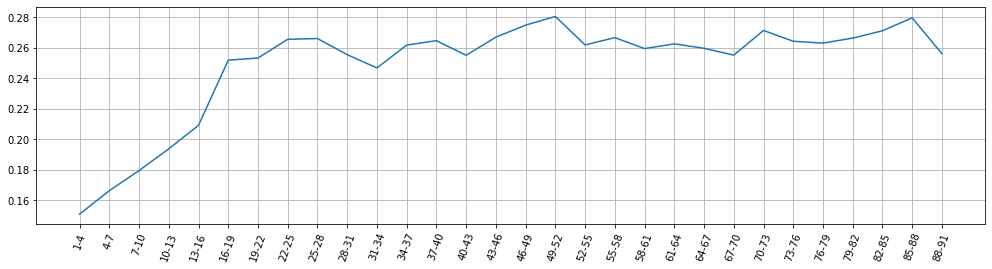

In [26]:
plt.figure(figsize=(17,4))
plt.plot(np.arange(len(list_interval)), result_precision)
plt.xticks(np.arange(len(list_interval)), list_interval, rotation=70)
plt.grid()

In [27]:
%%time
# Берем для трейна 6 первые недели, а для валидации 6 следующие недели.

interval_6 = 1
list_interval_6 = []
result_precision_6 = []

while interval_6 < 80:
#1, 7, 13, 19, 25, 31, 37, 43, 49, 55, 61, 67, 73, 79, |85, 91

    data_train_part = data[(data['week_no'] >= interval_6) & (data['week_no'] < interval_6 + 6)]
    data_val_part = data[(data['week_no'] >= interval_6 + 6) & (data['week_no'] < interval_6 + 12)]
    
    result_ = data_val_part.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_.columns=[USER_COL, ACTUAL_COL]
    
    result_[f'self_pop_rec_part'] = result_['user_id'].apply(lambda x: self_popularity_rec(x, data_train_part, n=N_PREDICT))
    final_result = result_.apply(lambda row: precision_at_k(row[f'self_pop_rec_part'], row['actual']), axis=1).mean()
    
    list_interval_6.append(f'{interval_6}-{interval_6+6}')
    result_precision_6.append(round(final_result, 4))
    
    interval_6 += 6
print(interval_6)

85
Wall time: 2min 40s


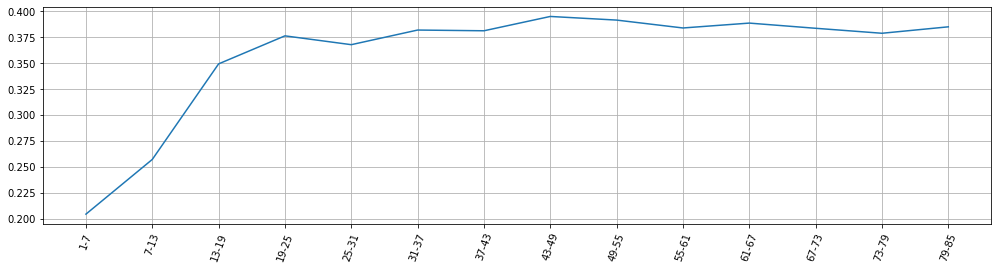

In [28]:
plt.figure(figsize=(17,4))
plt.plot(np.arange(len(list_interval_6)), result_precision_6)
plt.xticks(np.arange(len(list_interval_6)), list_interval_6, rotation=70)
plt.grid()

In [29]:
# Поскольку на тесте у нас всего 3 недели, то сравним эти 3 недели с остальными возрастающими интервалами
# интервал валидации 2,3,4 недели с 1 неделей
# интервал валидации 3,4,5 недели с 1,2 неделями
# интервал валидации 4,5,6 недели с 1,2,3 неделями
# ...

num_week_interval = []
result_precision = []

for num_week in tqdm(np.arange(1, 93, 1)):
# 1, 8, 15, 22, 29, 36, 43, 50, 57, 64, 71, 78, | 85, 92

    data_train_part = data[data['week_no'] < num_week + 1]
    
    data_val_part = data[(data['week_no'] > num_week) & (data['week_no'] <= num_week + 3)]
    
    result_ = data_val_part.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result_.columns=[USER_COL, ACTUAL_COL]
    result_[f'self_pop_rec_part'] = result_['user_id'].apply(lambda x: self_popularity_rec(x, data_train_part, n=N_PREDICT))
    final_result = result_.apply(lambda row: precision_at_k(row[f'self_pop_rec_part'], row['actual']), axis=1).mean()
    
    num_week_interval.append(f'{num_week+1},{num_week+2},{num_week+3} --> {num_week}')
    result_precision.append(round(final_result, 4))

100%|██████████████████████████████████████████████████████████████████████████████████| 92/92 [19:58<00:00, 13.03s/it]


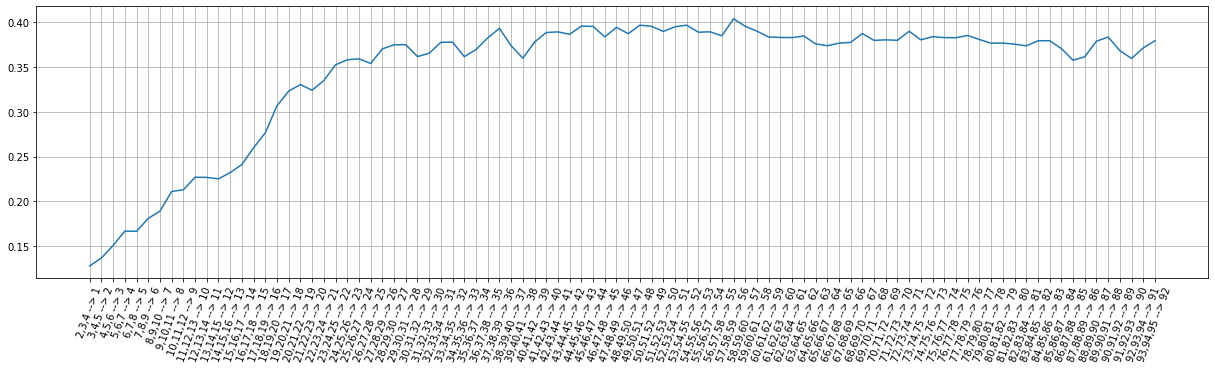

In [30]:
plt.figure(figsize=(21,5))
plt.plot(np.arange(len(num_week_interval)), result_precision)
plt.xticks(np.arange(len(num_week_interval)), num_week_interval, rotation=70)
plt.grid()

Данные графики говорят о том, что рекомендации, построенные на собственных покупках пользователя за предыдущий интервал(3 недели) времени, достаточно качественны(точность) и полученный результат precision@5 = 0.35 на части датасета(data_train_ranker) устойчив.

# Второй уровень. Улучшение базовой модели 1-го уровня. <a class='anchor' id='second_level'>

In [31]:
# Подготовка данных для трейна
X_train, y_train = create_second_level(data_train_ranker, data_train, data_val, item_features, user_features)
X_train.head()

,user_id,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,...,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_check,quantity_purchases_in_cat,mean_purch_per_week,mean_comm_per_week,mean_sales_item_per_cat-sales_value,cnt_sales-mean_sales_per_cat
0,84,903529.0,539,DRUG GM,National,CIGARETTES,CIGARETTES,972976 PK,NaN,NaN,...,NaN,NaN,NaN,NaN,16.04625,10.0,1.354839,107.280899,198.069048,-1.180328
1,84,829722.0,70,GROCERY,National,LAUNDRY DETERGENTS,LIQUID LAUNDRY DETERGENTS,32 LOAD,NaN,NaN,...,NaN,NaN,NaN,NaN,16.04625,8.0,2.030303,63.865169,598.241940,3.872186
2,84,920025.0,764,GROCERY,National,LAUNDRY ADDITIVES,FABRIC SOFTENER LIQUID,60 LOAD,NaN,NaN,...,NaN,NaN,NaN,NaN,16.04625,8.0,1.600000,28.764045,409.926389,5.064220
3,84,1080414.0,693,DRUG GM,National,CANDY - CHECKLANE,CANDY BARS (SINGLES)(INCLUDING,1.6 OZ,NaN,NaN,...,NaN,NaN,NaN,NaN,16.04625,3.0,13.285714,303.000000,79.980645,0.090535
4,84,5569374.0,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ,NaN,NaN,...,NaN,NaN,NaN,NaN,16.04625,4.0,9.000000,487.730337,4111.252462,-15.930211


In [32]:
y_train.value_counts()

0.0    94638
1.0    25040
Name: target, dtype: int64

In [33]:
cat_features = X_train.select_dtypes(include=['object']).columns.tolist()
cat_features

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc']

In [34]:
X_train[cat_features + ['user_id', 'item_id']] = X_train[cat_features + ['user_id', 'item_id']].astype('category')

In [35]:
drop_list = []

lgbc = LGBMClassifier(categorical_feature=cat_features,
                      n_estimators=672,
                      class_weight='balanced',
                      num_leaves=36,
                      max_depth=9)

lgbc.fit(X_train.drop(drop_list, axis=1), y_train)

LGBMClassifier(boosting_type='gbdt',
               categorical_feature=['department', 'brand', 'commodity_desc',
                                    'sub_commodity_desc',
                                    'curr_size_of_product', 'age_desc',
                                    'marital_status_code', 'income_desc',
                                    'homeowner_desc', 'hh_comp_desc',
                                    'household_size_desc',
                                    'kid_category_desc'],
               class_weight='balanced', colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=9,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=672, n_jobs=-1, num_leaves=36, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

Text(0.5, 1.0, 'What are the top important features to start with?')

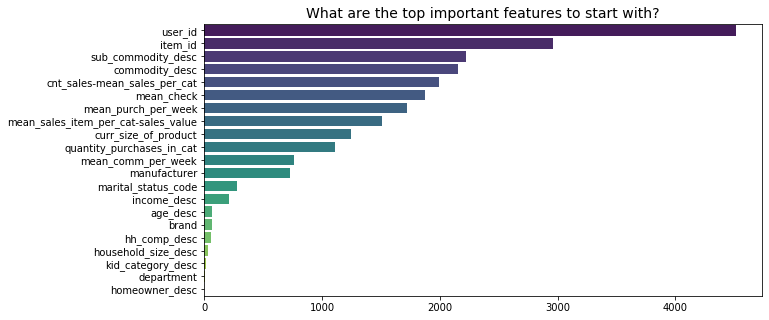

In [36]:
n_top = 50
importances = lgbc.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = X_train.drop(drop_list, axis=1).columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances[idx], y=feature_names[idx], palette="viridis", orient='h')
plt.title("What are the top important features to start with?", size=14)

In [37]:
# Подготовка данных для теста
X_test_df, y_test_df = create_second_level(df_test, data_train, data_val, item_features, user_features)
X_test_df[cat_features + ['user_id', 'item_id']] = X_test_df[cat_features + ['user_id', 'item_id']].astype('category')

In [38]:
test_preds_proba = lgbc.predict_proba(X_test_df.drop(drop_list, axis=1))[:, 1]
test_preds_proba
result_final = get_final_rec(X_test_df.drop(drop_list, axis=1), test_preds_proba)
result_final.apply(lambda row: precision_at_k(row['rec'], row['actual']), axis=1).mean()

0.38884758364312294

#### precision@5 > 0.38

In [40]:
lgbc = LGBMClassifier(categorical_feature=cat_features,
                      n_estimators=672,
                      class_weight='balanced',
                      num_leaves=36,
                      max_depth=9)
my_tuple = {}

for col in tqdm(X_train.columns.tolist()[2:]):
    X_test_df2 = X_test_df.copy()
    
    lgbc.fit(X_train.drop(col, axis=1), y_train)
    
    test_preds_proba = lgbc.predict_proba(X_test_df2.drop(col, axis=1))[:, 1]

    result_final = get_final_rec(X_test_df2.drop(col, axis=1), test_preds_proba)
    
    my_tuple[col] = result_final.apply(lambda row: precision_at_k(row['rec'], row['actual']), axis=1).mean()

100%|██████████████████████████████████████████████████████████████████████████████████| 19/19 [04:21<00:00, 13.76s/it]


In [41]:
my_tuple

{'manufacturer': 0.3848114710568251,
 'department': 0.38661710037174846,
 'brand': 0.3861922464152955,
 'commodity_desc': 0.3857673924588432,
 'sub_commodity_desc': 0.38544875199150386,
 'curr_size_of_product': 0.38247477429633653,
 'age_desc': 0.3868295273499744,
 'marital_status_code': 0.3850238980350511,
 'income_desc': 0.3834306956983546,
 'homeowner_desc': 0.385873605947956,
 'hh_comp_desc': 0.3841741901221465,
 'household_size_desc': 0.3872543813064271,
 'kid_category_desc': 0.38236856080722365,
 'mean_check': 0.38513011152416426,
 'quantity_purchases_in_cat': 0.3877854487519921,
 'mean_purch_per_week': 0.3842804036112594,
 'mean_comm_per_week': 0.38459904407859863,
 'mean_sales_item_per_cat-sales_value': 0.38141263940520487,
 'cnt_sales-mean_sales_per_cat': 0.3802442910249607}

Удаление какого-либо признака при неизменных гиперпараметрах модели не улучшает точность.

In [67]:
result_final['rec'] = result_final['rec'].apply(lambda x: list(map(int, x)))

In [69]:
# сохранение в файл
result_final[['user_id', 'rec']].to_csv('recommendations.csv', index=False)


# Выводы. <a class='anchor' id='end'>

**Поставленная задача выполнена, показатель точности на тесте(precision@5, данные для курсовой) составил > 0.38**

В ходе работы также был применен метод ALS, однако показатель точности(precision@5) в экспериментах при текущих фичах и несильно большой сложности ML модели не превышал 0.25.

Дальнейшее повышение качества рекомендаций при использовании метода 'self_popular_rec' может быть достигнуто за счет:
* Выявления закономерностей на основании истории покупок покупателя (в том числе в разных временных разрезах, по корзинам покупок);
* Формирования и отбора новых фичей на данных для второго уровня модели рекомендации;
* Более точного подбора гиперпараметров ML модели(усложнения модели);
* Ансамблирования ML моделей.


Необходимо отметить, что в данной работе применялся подход "теплый старт", поэтому при изменении подхода на "холодный старт" метод 'self_popular_rec' на новом пользователе работать не будет. В этой связи будет необходимо для нового пользователя найти похожих пользователей при помощи, например, ALS/FAISS и затем использовать метод 'self_popular_rec'(или найти вектор похожих товаров, что часто не дает хорошую точность).

При построении первого уровня рокемендаций с ALS, необходимо также рассматривать совместно первый и второй уровни, поскольку, например, понижение take_n_popular в префильтрации данных(def prefilter_items) повышает точность с ALS на первом уровне, но может ухудшить или дать небольшой прирост точности на модели второго уровня.

Далее важным замечанием является то, что метод 'self_popular_rec'("теплый старт") не обеспечивает разнообразия товаров для конкретного пользователя и может опаздывать за меняющимся интересом покупателя, например, когда алгоритм будет предлагать пользователю популярные товары этого же пользователя и чтобы в этот Топ-n популярных товаров попал новый товар, пользователю целенаправленно нужно брать не свои популярные товары, иначе алгоритм будет предлагать одно и то же. Таким образом, сложнее будет определить что еще пользователю потенциально может быть интересно. Более того, однообразие рекомендаций может способствовать оттоку покупателей. 

Поэтому возможно стоило бы использовать метод 'self_popular_rec' в увязке с другими методами.

